In [1]:
!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbb_terminal.sdk import openbb
import statsmodels.api as sm
from statsmodels import regression

In [2]:
plt.style.use("default")
plt.rcParams["figure.figsize"] = [5.5, 4.0]
plt.rcParams["figure.dpi"] = 140
plt.rcParams["lines.linewidth"] = 0.75
plt.rcParams["font.size"] = 8

In [3]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "SPY"]
data = openbb.economy.index(
    symbols, 
    start_date="2020-01-01", 
    end_date="2022-12-31"
)

yfinance: download(show_errors=False) argument is deprecated and will be removed in future version. Do this instead to suppress error messages: logging.getLogger('yfinance').setLevel(logging.CRITICAL)


In [4]:
benchmark_returns = (
    data
    .pop("SPY")
    .pct_change()
    .dropna()
)

In [5]:
portfolio_returns = (
    data
    .pct_change()
    .dropna()
    .sum(axis=1)
)
portfolio_returns.name = "portfolio"

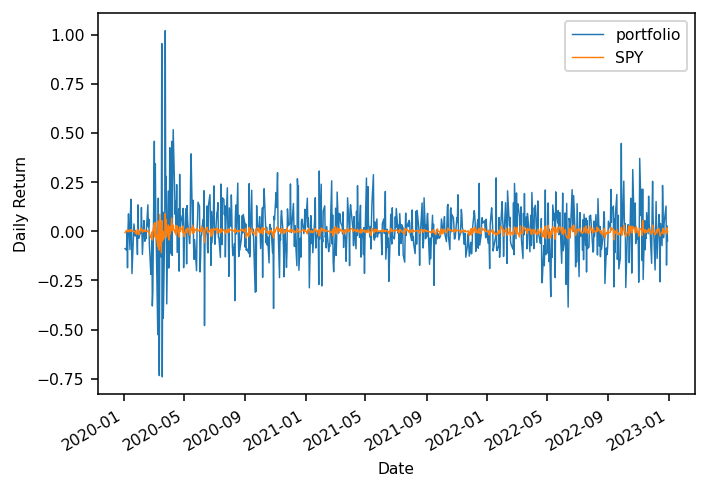

In [6]:
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()

In [7]:
X = benchmark_returns.values
Y = portfolio_returns.values

def linreg(x, y):
    # Add a column of 1s to fit alpha
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]


alpha, beta = linreg(X, Y)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.0028403361404649497
Beta: 5.57445821966694


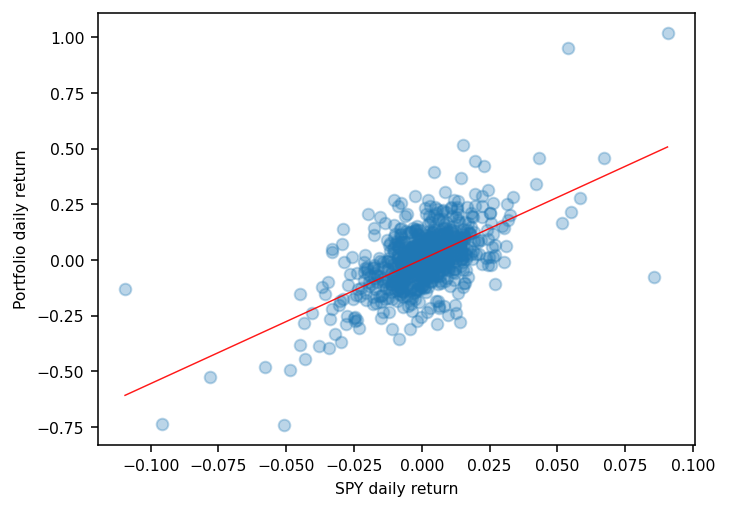

In [8]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

# Plot the raw data
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")

# Add the regression line
plt.plot(X2, Y_hat, "r", alpha=0.9)

In [9]:
# Construct a portfolio with beta hedging
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

In [10]:
P = hedged_portfolio_returns.values
alpha, beta = linreg(X, P)
print(f"Alpha: {alpha}")
print(f"Beta: {round(beta,6)}")

Alpha: 0.002840336140464947
Beta: 0.0


In [11]:
# information ratio
# https://pyquantnews.com/how-to-measure-skill-portfolio-manager/

In [12]:
def information_ratio(
    portfolio_returns, 
    benchmark_returns
):
    """
    Determines the information ratio of a strategy.
    
    Parameters
    ----------
    portfolio_returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    benchmark_returns : int, float
        Daily returns of the benchmark or factor, noncumulative.
    Returns
    -------
    information_ratio : float
    Note
    -----
    See https://en.wikipedia.org/wiki/Information_ratio for more details.
    """
    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    
    return active_return.mean() / tracking_error

In [13]:
hedged_ir = information_ratio(
    hedged_portfolio_returns, 
    benchmark_returns
)
unhedged_ir = information_ratio(
    portfolio_returns, 
    benchmark_returns
)
print(f"Hedged information ratio: {hedged_ir}")
print(f"Unhedged information ratio: {unhedged_ir}")

Hedged information ratio: 0.02107246568572774
Unhedged information ratio: 0.034651438933141515
